In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
import soundfile as sf
from IPython.display import Audio
import time

In [2]:
# Local imports from your project structure
from model.gru_audio_model import RNN, GRUAudioConfig
from audioDataLoader.mulaw import mu_law_encode, mu_law_decode

from utils.utils import multi_linspace, steps, plot_condition_tensor

from inference import run_inference

In [3]:

run_directory = "./output/20250806_160647" #'Path to the directory of the saved run.'
top_n = 5 #'Sample from the top N most likely outputs.'
temperature =1.0 #'Controls the randomness of predictions.'
length_seconds =2.0 #'Length of the audio to generate in seconds.'

sample_rate = 16000
generation_length = int(length_seconds * sample_rate)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#parser.add_argument('--output_wav_path', type=str, default='generated_audio.wav', help='Path to save the output WAV file.')
#parser.add_argument('--output_plot_path', type=str, default='generated_waveform.png', help='Path to save the output plot.')


In [4]:
# -------     Load model     -----------#

config_path = os.path.join(run_directory, "config.pt")
checkpoint_path = os.path.join(run_directory, "checkpoints", "last_checkpoint.pt")

assert os.path.exists(run_directory), f"Run directory not found: {run_directory}"
assert os.path.exists(config_path), f"Config file not found: {config_path}"
assert os.path.exists(checkpoint_path), f"Checkpoint file not found: {checkpoint_path}"

saved_configs = torch.load(config_path, weights_only=False)
model_config = saved_configs["model_config"]

model = RNN(model_config).to(device)
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Model successfully loaded from checkpoint.")


Model successfully loaded from checkpoint.


In [5]:

num_cond_params = model_config.cond_size
cond_seq = torch.zeros(generation_length, num_cond_params)
cond_seq[:, 0] = 0.0
#cond_seq[:, 0] = torch.linspace(0, 1, generation_length)
#cond_seq[:, 0] = torch.FloatTensor(multi_linspace([(0,1),(.2,1), (.8,0), (1,0)], generation_length))

#cond_seq[:, 1] = .9
#cond_seq[:, 1] = torch.FloatTensor(multi_linspace([(0,1),(.5,1), (1,1)], generation_length))
#cond_seq[:, 1] = torch.FloatTensor(multi_linspace([(0,1),(.5,1), (1,1)], generation_length))
cond_seq[:, 1] = torch.FloatTensor(multi_linspace([(0,1),(1/8-.03,.25), (1/8,.25), (1/8, 1), (2/8-.03, .25), (2/8, .25),(2/8, 1), (3/8-.03, .25), (3/8, .25),(3/8, 1), (4/8-.03, .25), (4/8, .25),(4/8, 1), (5/8-.03, .25), (5/8, .25), (5/8, 1), (6/8-.03, .25), (6/8, .25), (6/8, 1), (7/8-.03, .25), (7/8, .25), (7/8, 1), (1-.03, 1), (1, 1), (1,1)], generation_length))

#cond_seq[:, 2] = 4/12
cond_seq[:, 2] = torch.FloatTensor(steps(np.array([0,2,4,5,7,9,11,12])/12., generation_length))
#cond_seq[:, 2] = torch.FloatTensor(steps(np.array([12,11,9,7,5,4,2,0])/12., generation_length))
#cond_seq[:, 2] = torch.FloatTensor(steps(np.array([12,11,10, 11, 12, 12 ,12])/12., generation_length))
#cond_seq[:, 2] = torch.linspace(0, 1, generation_length)

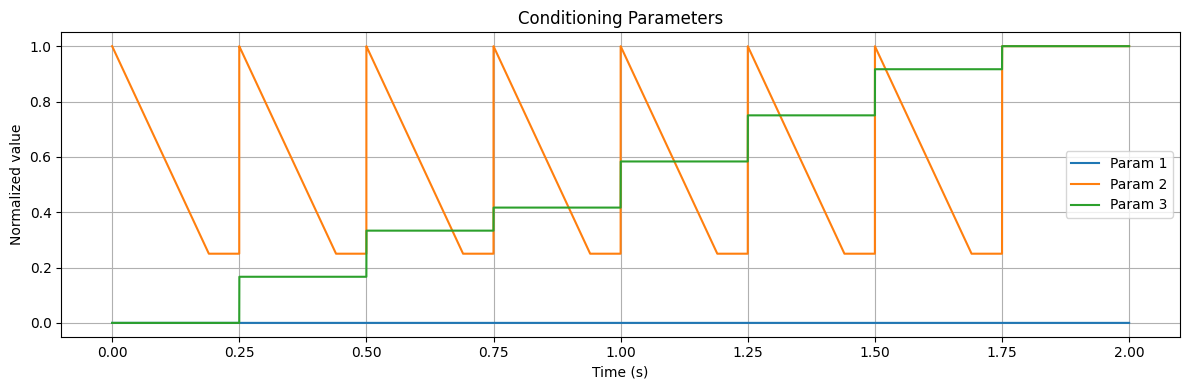

In [6]:
plot_condition_tensor(cond_seq, 16000)

In [7]:
warmup_len = 32
t = torch.linspace(0., 1., warmup_len)
warmup_sequence = torch.sin(2 * np.pi * 220.0 * t)

start_time = time.monotonic()
generated_audio = run_inference(
    model=model,
    cond_seq=cond_seq,
    warmup_sequence=warmup_sequence,
    top_n=top_n,
    temperature=temperature
)
elapsed_time = time.monotonic() - start_time
print(f"Time to generate: {elapsed_time:.2f}")

Starting inference...
Generating 32000 audio samples...
Inference complete.
Time to generate: 9.60


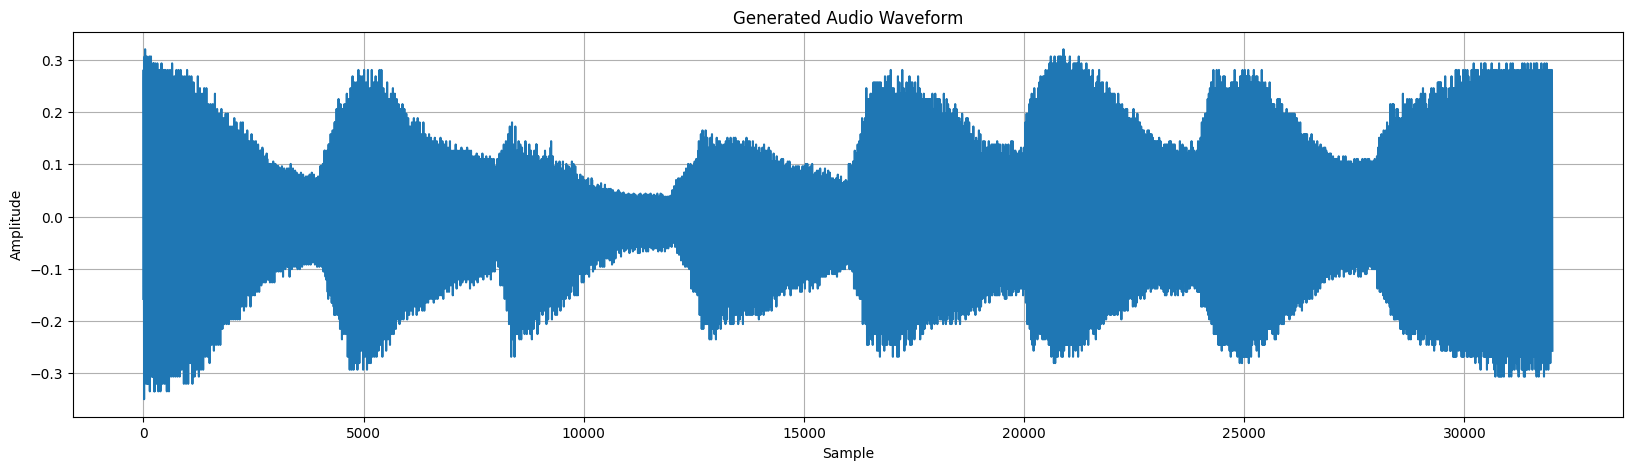

In [8]:
#print(f"Saving waveform plot to {args.output_plot_path}")
plt.figure(figsize=(20, 5))
plt.plot(generated_audio)
plt.title("Generated Audio Waveform")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
#plt.savefig(args.output_plot_path)
#plt.close()

plt.show()

In [9]:
Audio(generated_audio, rate=16000)